In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
from lesson_functions import *
from sklearn import linear_model
from tqdm import tqdm

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def plot_dual(img1, img2, title1='', title2='', figsize=(15,5)): 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    f.tight_layout()
    ax1.imshow(img1, cmap='gray') 
    ax1.set_title(title1)
    ax2.imshow(img2, cmap='gray')
    
def test_calibration(objpoints, imgpoints):
    num_img = len(camera_cal_list)
    idx = np.random.randint(0,num_img)
    test_img = cv2.imread('./camera_cal/calibration'+str(idx)+'.jpg')
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    dst = cal_undistort(test_img, objpoints, imgpoints)
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title(camera_cal_list[idx])
    plt.imshow(test_img)
    plt.subplot(1, 2, 2)
    plt.title('Undistorted')
    plt.imshow(dst)
    
def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [3]:
def camera_calibration(camera_cal_list, nx, ny, img_size=(720,1280)):
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,0:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    for i, image_name in enumerate(camera_cal_list):
        image = cv2.imread('./camera_cal/'+image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

def perspective_transform(src_points, dst_points):
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    return M, Minv

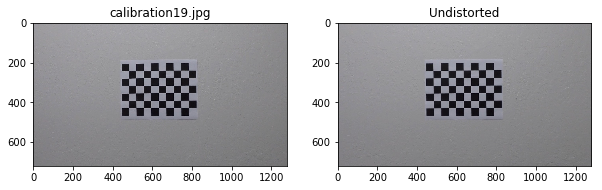

In [4]:
camera_cal_list = os.listdir('./camera_cal')
mtx, dist= camera_calibration(camera_cal_list, 9, 6)
test_calibration(mtx, dist)

In [5]:
def perspective_transform(src_points, dst_points):
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    return M, Minv

def warp_image(img, mtx):
    flag=cv2.INTER_LINEAR
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, mtx, img_size, flag)

In [6]:
src_pts = np.array([[240,720],[575,460],[715,460],[1150,720]], np.float32)
dst_pts = np.array([[440,720],[440,0],[950,0],[950,720]], np.float32)

M, Minv = perspective_transform(src_pts, dst_pts)

## Pipeline (single image)

### 1. Distortion-corrected image

In [ ]:
raw_img = cv2.imread('./test_images/test1.jpg')
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
undistorted_img = cal_undistort(raw_img, mtx, dist)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title('original image')
plt.imshow(raw_img)
plt.subplot(1,2,2)
plt.title('undistorted image')
plt.imshow(undistorted_img)


### 2. Perspective transform

### 3. Identified lane-line pixels and fit their positions with a polynomial

First I use `find_centroids` function to find the centroid in each window. then I use `find_xy` to find the point in each window. At the end of `find_xy` process I fit the lane line.

### 4. Calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

```python
def get_curvature(self, fit, y_eval):
    return ((1 + (2 * fit[0] * y_eval + fit[1]) ** 2) ** 1.5) / np.absolute(2 * fit[0])
def get_dist_center(self, fit):
    xm_per_pix = 3.7/(1280*0.57)
    real_center = (fit[1][2]+fit[0][2])/2
    dist = (640-real_center)*xm_per_pix
    return dist
```

I use `get_curvature` and `get_dist_center` functions to get the curvature and position of the vehicle.

### 3. Identified lane-line pixels and fit their positions with a polynomial

First I use `find_centroids` function to find the centroid in each window. then I use `find_xy` to find the point in each window. At the end of `find_xy` process I fit the lane line.

### 4. Calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

```python
def get_curvature(self, fit, y_eval):
    return ((1 + (2 * fit[0] * y_eval + fit[1]) ** 2) ** 1.5) / np.absolute(2 * fit[0])
def get_dist_center(self, fit):
    xm_per_pix = 3.7/(1280*0.57)
    real_center = (fit[1][2]+fit[0][2])/2
    dist = (640-real_center)*xm_per_pix
    return dist
```

I use `get_curvature` and `get_dist_center` functions to get the curvature and position of the vehicle.

## Read an car image for function testing

In [ ]:
test_img = cv2.imread('test_images/test_car.png')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
print('image shape: ', test_img.shape)
plt.imshow(test_img)

## Feature extraction function

Here I extracted HOG features from the image

In [7]:
from skimage.feature import hog

def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features
def bin_spatial(img, size=(32, 32)):
    copy_img = np.copy(img)
    features = cv2.resize(copy_img, size).ravel() 
    return features

def hog_features(img, orient, ppc, cpb, hog_channel=0):
    if hog_channel == 'ALL':
        hog_feature = []# ppc = pix_per_cell cpb = cell_per_block
        for c in range(3):
            features = hog(img[:,:,c], orientations=orient, pixels_per_cell=(ppc, ppc),
                       cells_per_block=(cpb, cpb), visualise=False, feature_vector=True)
            features.ravel()
            hog_feature.append(features)
        hog_feature = np.array(hog_feature).ravel()
    else:
        hog_feature = hog(img[:,:,hog_channel], orientations=orient, pixels_per_cell=(ppc, ppc), cells_per_block=(cpb, cpb), visualise=False, feature_vector=True)
        hog_feature.ravel()
    return hog_feature
    
def extract_features(image, cspace='RGB', spatial_size=(32,32), hist_bins=32): 
    features = [] # ppc = pix_per_cell cpb = cell_per_block
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image) 
        
    spatial = bin_spatial(feature_image, spatial_size)
    hog = hog_features(feature_image, 9, 8, 2, 'ALL')
    hist = color_hist(feature_image, nbins=hist_bins) 
    features = np.concatenate((spatial, hog, hist))
    return features



In [ ]:
features = extract_features(test_img, cspace='YCrCb', spatial_size=(32,32))
print(features.shape)

## Data prepare

In [ ]:
import glob

Car_data = []
nonCar_data = []
GTI_Far = glob.glob('./dataset/vehicles/vehicles/GTI_Far/*.png')
GTI_Left = glob.glob('./dataset/vehicles/vehicles/GTI_Left/*.png')
GTI_Right = glob.glob('./dataset/vehicles/vehicles/GTI_Right/*.png')
GTI_MiddleClose = glob.glob('./dataset/vehicles/vehicles/GTI_MiddleClose/*.png')
KITTI_extracted = glob.glob('./dataset/vehicles/vehicles/KITTI_extracted/*.png')
GTI_nonCar = glob.glob('./dataset/non-vehicles/non-vehicles/GTI/*.png')
Extras_nonCar = glob.glob('./dataset/non-vehicles/non-vehicles/Extras/*.png')
Car_data.extend(GTI_Far)
Car_data.extend(GTI_Left)
Car_data.extend(GTI_Right)
Car_data.extend(GTI_MiddleClose)
Car_data.extend(KITTI_extracted)
nonCar_data.extend(GTI_nonCar)
nonCar_data.extend(Extras_nonCar)

In [ ]:
print('NO. of GTI_Far: ', len(GTI_Far))
print('NO. of GTI_Left: ', len(GTI_Left))
print('NO. of GTI_Right: ', len(GTI_Right))
print('NO. of GTI_MiddleClose: ', len(GTI_MiddleClose))
print('NO. of KITTI_extracted: ', len(KITTI_extracted))
print()
print('NO. of GTI_nonCar: ', len(GTI_nonCar))
print('NO. of Extras_nonCar: ', len(Extras_nonCar))
print()
print('NO. of Car_data: ', len(Car_data))
print('NO. of nonCar_data: ', len(nonCar_data))

Car_data = np.array(Car_data)
nonCar_data = np.array(nonCar_data)
print(Car_data.shape, nonCar_data.shape)
X_list = np.hstack((Car_data, nonCar_data))
y = np.hstack((np.ones(Car_data.shape[0]), np.zeros(nonCar_data.shape[0])))

print(X_list)
print(y)
print('train_X: ',X_list.shape)
print('train_y: ',y.shape)

In [ ]:
import matplotlib.image as mpimg
def get_features(img_list, color_space='RGB', spatial_size=(32,32), hist_bins=32, orient=9, ppc=8, cpb=2, hog_channel='ALL'):
    features = []
    for file in tqdm(img_list):
        img = mpimg.imread(file)
        img_feature = extract_features(img, cspace=color_space, orient=orient, ppc=ppc, cpb=cpb,
                               spatial_size=spatial_size, hist_bins=hist_bins)
        features.append(img_feature)
    return np.array(features)

In [ ]:
X_features = get_features(X_list, color_space='YCrCb')
print(X_features.shape)

In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X_features)

In [ ]:
scaled_X = X_scaler.transform(X_features)

In [ ]:
print(np.max(X_features))
print(np.max(scaled_X))

## Save StandardScaler

In [ ]:
with open('./examples/X_scaler.p', 'wb') as pfile:
    pickle.dump(X_scaler, pfile)

## Save data to pickle file

In [ ]:
with open('./examples/X_features.p', 'wb') as pfile:
    pickle.dump(X_features, pfile, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('./examples/scaled_X.p', 'wb') as pfile:
    pickle.dump(scaled_X, pfile, pickle.HIGHEST_PROTOCOL)

## Load the training and test scaled data

In [ ]:
data_file = './examples/scaled_X.p'
with open(data_file, mode='rb') as f:
    scaled_X = pickle.load(f)

In [ ]:
from sklearn.cross_validation import train_test_split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

## SVM classifier

The `grid_search.GridSearchCV` return:

```python
GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)
```

I used `get_params()` method to get the parameters.

```python
{'cv': None,
 'error_score': 'raise',
 'estimator': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'estimator__C': 1.0,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': None,
 'estimator__degree': 3,
 'estimator__gamma': 'auto',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'fit_params': {},
 'iid': True,
 'n_jobs': 1,
 'param_grid': {'C': [1, 10], 'kernel': ('linear', 'rbf')},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'scoring': None,
 'verbose': 0}
```

The best parameters are following:

```python
{'C': 10, 'kernel': 'rbf'}
```
The test accuracy is 0.99577702702702697




In [ ]:
from sklearn import svm, grid_search
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

In [ ]:
clf.get_params()

In [ ]:
print(clf.best_params_)
print(clf.best_score_)

In [ ]:
clf.score(X_test, y_test)

## Save model

In [ ]:
import pickle
with open('./examples/model.p', 'wb') as pfile:
    pickle.dump(clf, pfile)

## Read model and StandardScale

In [8]:
data_file = './examples/model.p'
with open(data_file, mode='rb') as f:
    clf = pickle.load(f)
    
with open('./examples/X_scaler.p', mode='rb') as f:
    X_scaler = pickle.load(f)

## Detection Implementation

In [9]:
from scipy.ndimage.measurements import label

def extract_features_once_hog(image, hog_image, cspace='RGB', spatial_size=(32,32), hist_bins=32): 
    features = [] # ppc = pix_per_cell cpb = cell_per_block
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image) 
        
    spatial = bin_spatial(feature_image, spatial_size)
#     hog = hog_features(feature_image, 9, 8, 2, 'ALL')
    hist = color_hist(feature_image, nbins=hist_bins) 
    features = np.concatenate((spatial, hog, hist))
    return features
    
def hog_once(img, orient=9, ppc=8, cpb=2):
    hog_feature = []# ppc = pix_per_cell cpb = cell_per_block
    for c in range(3):
        features = hog(img[:,:,c], orientations=orient, pixels_per_cell=(ppc, ppc),
                   cells_per_block=(cpb, cpb), visualise=False, feature_vector=False)
        hog_feature.append(features)
    hog_feature = np.array(hog_feature)
    return hog_feature

def draw_labeled_bboxes(img, labels):
    draw_img = np.copy(img)
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
    return draw_img 

def heat_map(img, hit_window):
    heatmap = np.zeros((img.shape[0],img.shape[1]), dtype=np.uint8)
    for box in hit_window:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap
    
def loop_windows(img, window_list, thresh=5):
    hit_window = []
#     for window in tqdm(window_list):
    for window in window_list:
        win_img = cv2.resize(img[window[0][1]:window[1][1],window[0][0]:window[1][0],:], (64, 64))
        features = extract_features(win_img, cspace='YCrCb')
        scaled_X = X_scaler.transform(features)
        prediction = clf.predict(scaled_X)
        if prediction == 1:
            hit_window.append(window)
    heat_img = heat_map(img, hit_window)
    heat_img = apply_threshold(heat_img, thresh)
    labels = label(heat_img)
    return heat_img, labels, hit_window
    
def detection(img):
    draw_img = np.copy(img)
    window_list_0 = slide_window(img, [None, None], [410,500], (80,50), (0.9,0.6))#OK
    window_list_1 = slide_window(img, [None, None], [410,510], (100,100), (0.9,0.5))#OK
    window_list_2 = slide_window(img, [None, None], [400,550], (200,150), (0.9,0.5))
    window_list_3 = slide_window(img, [None, None], [400,600], (200,200), (0.9,0.5))
    window_list_4 = slide_window(img, [None, None], [400,600], (300,230), (0.9,0.5))
    window_list_5 = slide_window(img, [None, None], [400,656], (300,256), (0.9,0.5))#OK
    window_list = []
    window_list.extend(window_list_0)
    window_list.extend(window_list_1)
    window_list.extend(window_list_2)
    heat_img0, labels0, hit_window = loop_windows(img, window_list, 3)
    draw_img = draw_boxes(draw_img, hit_window)
    
    window_list = []
    window_list.extend(window_list_3)
    window_list.extend(window_list_4)
    window_list.extend(window_list_5)
    heat_img1, labels1, hit_window = loop_windows(img, window_list, 8)
    draw_img = draw_boxes(draw_img, hit_window)
    heat_img = heat_img0 + heat_img1
    labels = labels0 + labels1
    return draw_img, heat_img, labels 

In [ ]:
# test_img = mpimg.imread('./test_images/test1.jpg')
# test_img = mpimg.imread('./test_images/test3.jpg')
# test_img = mpimg.imread('./test_images/test4.jpg')
# test_img = mpimg.imread('./test_images/test5.jpg')
# test_img = mpimg.imread('./test_images/test6.jpg')
test_img = mpimg.imread('./output_images/test_video_frame22.jpg')
test_img = (test_img - np.min(test_img))/(np.max(test_img) - np.min(test_img))
test_img = np.float32(test_img)
draw_img, heat_img, labels = detection(test_img)
label_img = draw_labeled_bboxes(test_img, labels)

plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.imshow(test_img)
plt.subplot(2,2,2)
plt.imshow(draw_img)
plt.subplot(2,2,3)
plt.imshow(heat_img, cmap='gray')
plt.subplot(2,2,4)
plt.imshow(label_img)

## Lane Finding Class

In [212]:
from collections import deque
class Detection():
    def __init__(self, win_width, mtx, dist, M, Minv):
        self.previous_fit_l = []
        self.previous_fit_r = []
        self.previous_fit = []
        self.previous_centroids = []
        self.allx = [] 
        self.ally = [] 
        self.mtx = mtx 
        self.dist= dist 
        self.M = M 
        self.Minv= Minv 
        self.nwindows = 9 
        self.win_width = win_width
        self.history_heats = deque(maxlen=5)
        self.history_labels = deque(maxlen=5)
    def find_refwin(self, window_centroids, window_boole):
        num = len(window_centroids)
        center = 0
        for i in range(num, 0, -1):
            if window_boole[i-1] == True:
                center = window_centroids[i-1]
                break
        return center
    def find_centroids(self, img, space_search=100): 
        window = np.ones(self.win_width)
        window_centroids_l = []
        window_centroids_r = []
        window_boole_l = []
        window_boole_r = []
        win_height = img.shape[0]/self.nwindows 
        bottom_sum_l = np.sum(img[int(3*img.shape[0]/4):,:640], axis=0)
        bottom_sum_r = np.sum(img[int(3*img.shape[0]/4):,640:], axis=0)
        conv_signal_l = np.convolve(window, bottom_sum_l)
        conv_signal_r = np.convolve(window, bottom_sum_r)
        center_l = int(np.argmax(conv_signal_l)-self.win_width/2)
        center_r = int(np.argmax(conv_signal_r)-self.win_width/2)+640
        previous_centroids = np.array(self.previous_centroids)
        if self.previous_centroids==[] or abs(center_l-previous_centroids[0,0])<50:
            window_centroids_l.append(center_l)
        else:
            window_centroids_l.append(previous_centroids[0,0])
        if self.previous_centroids==[] or abs(center_r-previous_centroids[1,0])<50:
            window_centroids_r.append(center_r)
        else:
            window_centroids_r.append(previous_centroids[1,0])
        window_boole_l.append(True)
        window_boole_r.append(True)
        for i in range(1, self.nwindows):
            window_ref_l = self.find_refwin(window_centroids_l, window_boole_l)
            window_ref_r = self.find_refwin(window_centroids_r, window_boole_r)
            min_index_l = int(max(window_ref_l-space_search,0))
            max_index_l = int(min(window_ref_l+space_search,640))
            min_index_r = int(max(window_ref_r-space_search,640))
            max_index_r = int(min(window_ref_r+space_search,img.shape[1]))
            start_y = int(img.shape[0]-(i+1)*win_height)
            end_y = int(img.shape[0]-i*win_height)
            image_layer_l = np.sum(img[start_y:end_y, min_index_l:max_index_l],axis=0)
            image_layer_r = np.sum(img[start_y:end_y, min_index_r:max_index_r],axis=0)
            conv_signal_l = np.convolve(window, image_layer_l)
            conv_signal_r = np.convolve(window, image_layer_r)
            offset = int(self.win_width/2)
            window_center_l = np.argmax(conv_signal_l)+min_index_l-offset
            window_center_r = np.argmax(conv_signal_r)+min_index_r-offset
            window_centroids_l.append(window_center_l)
            window_centroids_r.append(window_center_r)
            if abs(window_center_l-window_ref_l)<100:
                window_boole_l.append(True)
            else:
                window_boole_l.append(False)
            if abs(window_center_r-window_ref_r)<100:
                window_boole_r.append(True)
            else:
                window_boole_r.append(False)
        window_centroids = [window_centroids_l,window_centroids_r]
        window_boole = [window_boole_l, window_boole_r]
        self.previous_centroids = window_centroids
        return np.array(window_centroids), np.array(window_boole)
    def find_xy(self, img, window_centroids, window_boole):
        self.allx[:] = []
        self.ally[:] = []
        binary_img = img
        win_height = img.shape[0]/self.nwindows 
        nonzero = binary_img.nonzero()
        nonzeroy = nonzero[0]
        nonzerox = nonzero[1]
        for window in range(2):
            index = 0
            x = []
            y = []
            for i in range(9):
                if window_boole[window,i] == True:
                    center = window_centroids[window,i]
                    start_y = int(img.shape[0]-(i+1)*win_height)
                    end_y = int(img.shape[0]-i*win_height)
                    start_x = int(max(center-self.win_width/2, 0))
                    end_x = int(min(center+self.win_width/2, img.shape[1]))
                    binary_img[start_y:end_y,start_x:end_x] = 128
                    for idx in range(len(nonzerox)):
                        if nonzeroy[idx]>start_y and nonzeroy[idx]<end_y:
                            if nonzerox[idx]>start_x and nonzerox[idx]<end_x:
                                x.append([index,nonzerox[idx]])
                                y.append([index,nonzeroy[idx]])
                                index += 1
            self.allx.append(x)
            self.ally.append(y)
        return binary_img
    def line_fit(self, img, window_boole, margin=10):
        ym_per_pix = 23/img.shape[0]
        previous_fit_l = self.previous_fit_l
        previous_fit_r = self.previous_fit_r
        num_win_l = len([i for i in window_boole[0] if i])
        num_win_r = len([i for i in window_boole[1] if i])
        num_win = [num_win_l, num_win_r]
        out_img = np.zeros((img.shape[0],img.shape[1],3), dtype=np.uint8)
        total_fit = []
        for idx in range(2):
            if num_win[idx]>1:
                y = np.array(self.ally[idx])
                x = np.array(self.allx[idx])
                py = y[:,1]
                px = x[:,1]
                ransac = linear_model.RANSACRegressor(residual_threshold=40, random_state=50)
                ransac.fit(y,x)
                inlier_mask = ransac.inlier_mask_
                outlier_mask = np.logical_not(inlier_mask)
                fit = np.polyfit(py[inlier_mask], px[inlier_mask], 2)
                if idx == 0: #left
                    self.previous_fit_l = fit
                elif idx == 1:#right
                    self.previous_fit_r = fit
                ploty= np.linspace(0, img.shape[0]-1, img.shape[0])
                plotx = fit[0]*ploty**2+fit[1]*ploty+fit[2]
                line_window1 = np.array([np.transpose(np.vstack([plotx-margin, ploty]))])
                line_window2 = np.array([np.flipud(np.transpose(np.vstack([plotx+margin,ploty])))])
                line_pts = np.hstack((line_window1, line_window2))
                out_img[y[:,1], x[:,1],:] = [255, 0, 0]
                out_img[py[inlier_mask], px[inlier_mask], :]= [255, 255, 0]
                out_img[py[outlier_mask], px[outlier_mask], :] = [0, 255, 255]
                cv2.fillPoly(out_img, np.int_([line_pts]), (0, 0, 255))
                total_fit.append(fit)
            else:
                if idx == 0: #left
                    fit = self.previous_fit_l
                elif idx == 1:#right
                    fit = self.previous_fit_r
                ploty= np.linspace(0, img.shape[0]-1, img.shape[0])
                plotx = fit[0]*ploty**2+fit[1]*ploty+fit[2]
                line_window1 = np.array([np.transpose(np.vstack([plotx-margin, ploty]))])
                line_window2 = np.array([np.flipud(np.transpose(np.vstack([plotx+margin,ploty])))])
                line_pts = np.hstack((line_window1, line_window2))
                cv2.fillPoly(out_img, np.int_([line_pts]), (255, 0, 255))
                total_fit.append(fit)
        ploty= np.linspace(0, img.shape[0]-1, img.shape[0])
        left_plotx = total_fit[0][0]*ploty**2+total_fit[0][1]*ploty+total_fit[0][2]
        right_plotx= total_fit[1][0]*ploty**2+total_fit[1][1]*ploty+total_fit[1][2]
        line_window1 = np.array([np.transpose(np.vstack([left_plotx+margin, ploty]))])
        line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_plotx-margin,ploty])))])
        line_pts = np.hstack((line_window1, line_window2))
        cv2.fillPoly(out_img, np.int_([line_pts]), (255, 0, 0))
        left_curvature, right_curvature, dist = self.get_curvature(total_fit) 
        return out_img, np.array(total_fit), np.array([left_curvature, right_curvature]), dist
    def equalizeHist(self, img):
        output = np.copy(img)
        output[:,:,0]= cv2.equalizeHist(output[:,:,0])
        output[:,:,1]= cv2.equalizeHist(output[:,:,1])
        output[:,:,2]= cv2.equalizeHist(output[:,:,2])
        return output
    def undistort_img(self, img, mtx, dist):
        return cv2.undistort(img, mtx, dist, None, mtx)
    def warp_image(self, img, mtx):
        flag=cv2.INTER_LINEAR
        img_size = (img.shape[1], img.shape[0])
        return cv2.warpPerspective(img, mtx, img_size, flag)
    def gradient_x(self, img, kernel_size = 3, thresh=(0,255)):
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return sxbinary
    def get_curvature(self, fit):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/719 # meters per pixel in x dimension
        ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
        left_fit = fit[0]
        right_fit = fit[1]
        leftx = np.array([left_fit[0]*y**2+left_fit[1]*y+left_fit[2]+ np.random.randint(-50, high=51) for y in ploty])
        rightx = np.array([right_fit[0]*y**2+right_fit[1]*y+right_fit[2]+ np.random.randint(-50, high=51) for y in ploty])
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        y_eval = np.max(ploty) 
        if left_fit[0] != 0:
            left_curv = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
        else:
            left_curv = np.inf
        if right_fit[0] != 0:
            right_curv = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
        else:
            right_curv = np.inf
            
        dist = self.get_dist_center(np.array([left_fit_cr, right_fit_cr]))
        return left_curv, right_curv, dist
    def get_dist_center(self, fit):
        xm_per_pix = 3.7/719
        real_center = (fit[1][2]+fit[0][2])/2
        dist = (640*xm_per_pix-real_center)
        return dist
    def preprocess_img(self, img, sobel_ksize=3):
        img = np.copy(img) #RGB
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hsv[:,:,1]
        s_channel = hsv[:,:,2]
        light_mask = np.zeros_like(l_channel)
        light_mask[(s_channel>=5) & (l_channel>=130)] = 1
        gradx_l = self.gradient_x(l_channel, sobel_ksize, (25, 100))
        gradx_s = self.gradient_x(s_channel, sobel_ksize, (10, 100))
        combined = np.zeros_like(gradx_s)
        combined[((gradx_l == 1) | (gradx_s == 1)) & (light_mask == 1)] = 1
        color_binary = np.uint8(combined*255)
        return color_binary 
    def detection(self, img):
        img = (img - np.min(img))/(np.max(img) - np.min(img))
        img = np.float32(img)
        window_list = []
        window_list_0 = slide_window(img, [None, None], [410,500], (80,50), (0.9,0.6))#OK
        window_list_1 = slide_window(img, [None, None], [410,510], (100,100), (0.9,0.5))#OK
        window_list_2 = slide_window(img, [None, None], [400,528], (200,150), (0.9,0.5))
        window_list_3 = slide_window(img, [None, None], [400,528], (200,200), (0.9,0.5))
        window_list_4 = slide_window(img, [None, None], [400,600], (300,230), (0.95,0.5))
        window_list_5 = slide_window(img, [None, None], [400,656], (300,256), (0.95,0.5))#OK
        window_list = []
        window_list.extend(window_list_0)
        window_list.extend(window_list_1)
        window_list.extend(window_list_2)
        heat_img0, labels0, hit_window = loop_windows(img, window_list, 5)
        
        window_list = []
        window_list.extend(window_list_3)
        window_list.extend(window_list_4)
        window_list.extend(window_list_5)
        heat_img1, labels1, hit_window = loop_windows(img, window_list, 8)
        
        heat_img = heat_img0 + heat_img1
        labels = labels0 + labels1
        self.history_heats.append(heat_img)
#         labels = label(heat_img)
        self.history_labels.append(labels)
        return labels, heat_img
    def find_lane(self, img, sobel_ksize=3):
        labels, heat_img= self.detection(img)
#         _, heat_img= self.detection(img)
        for i in range(len(self.history_labels)):
            heat_img += self.history_heats[i]
            labels += self.history_labels[i]
#         heat_img = apply_threshold(heat_img, 3)
#         labels = label(heat_img)
#         output_img = draw_labeled_bboxes(img, labels)
        undistorted_img = self.undistort_img(img, self.mtx, self.dist)
        preprocessed_img = self.preprocess_img(undistorted_img, sobel_ksize)
        perspective_img = self.warp_image(preprocessed_img, self.M)
        window_centroids, window_boole = self.find_centroids(perspective_img)
        binary_img = self.find_xy(perspective_img, window_centroids, window_boole)
        lanes_img, fit, curvature, dist = self.line_fit(perspective_img, window_boole)
        lanes_img = self.warp_image(lanes_img, self.Minv)
#         curv = (curvature[0]+curvature[1])/2
#         cv2.putText(lanes_img, 'curv: %.2f'%curv, (50,50), cv2.FONT_HERSHEY_COMPLEX , 1.0, (255,255,255))
#         cv2.putText(lanes_img, 'dist: %.2f'%dist, (50,100), cv2.FONT_HERSHEY_COMPLEX , 1.0, (255,255,255))
        output_img = cv2.addWeighted(undistorted_img, 1, lanes_img, 0.8, 0)
        output_img = draw_labeled_bboxes(output_img, labels)
        return output_img
#         return heat_img
#         return labels

## Save frame for testing

In [154]:
clip_test = VideoFileClip("project_video.mp4").subclip(29,30).iter_frames()
# clip_test = VideoFileClip("test_video.mp4").iter_frames()
i = 0
for frame in clip_test:
    fname = './output_images/test_video_frame'+str(i)+'.jpg'
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imwrite(fname, frame)
    i = i+1

## Process video

In [217]:
video_lane = Detection(win_width=40, mtx=mtx, dist=dist, M=M, Minv=Minv)

def process_image(img):
    out_img = np.zeros_like(img)
    out_img = video_lane.find_lane(img)
    return out_img 

In [161]:
for i in tqdm(range(0,20)):
    filename = './output_images/test_video_frame'+str(i)+'.jpg'
    img = mpimg.imread(filename)
    out_img = video_lane.find_lane(img)
    cv2.imwrite('./test_out/test_video_frame'+str(i)+'.jpg', out_img)

100%|██████████| 20/20 [07:28<00:00, 22.40s/it]


In [ ]:
plt.figure(figsize=(12,20))
for i in range(0,6):
    filename = './output_images/test_video_frame'+str(i)+'.jpg'
    filename_o = './test_out/test_video_frame'+str(i)+'.jpg'
    img = mpimg.imread(filename)
    img_o = mpimg.imread(filename_o)
    plt.subplot(6,2,i*2+1)
    plt.imshow(img)
    plt.subplot(6,2,i*2+2)
    plt.imshow(img_o, cmap='gray')

In [ ]:
num_test_pic = len(os.listdir('./output_images/'))
print('The number of test pic: ', num_test_pic)

In [ ]:
video_test_output = 'videos_output/test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip1 = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1.write_videofile(video_test_output, audio=False)

[MoviePy] >>>> Building video videos_output/test_video_output.mp4
[MoviePy] Writing video videos_output/test_video_output.mp4


 18%|█▊        | 7/39 [02:37<11:58, 22.44s/it]

In [215]:
video_lane = Detection(win_width=40, mtx=mtx, dist=dist, M=M, Minv=Minv)

def process_image(img):
    out_img = np.zeros_like(img)
    out_img = video_lane.find_lane(img)
    return out_img 

In [ ]:
video_test_output = 'videos_output/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(20,35)
clip1 = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1.write_videofile(video_test_output, audio=False)

[MoviePy] >>>> Building video videos_output/project_video_output.mp4
[MoviePy] Writing video videos_output/project_video_output.mp4


 12%|█▏        | 152/1261 [56:53<6:55:15, 22.47s/it]